In [2]:
# Connect to the device
import belay
device = belay.Device("COM5")

In [3]:
@device.task
def getDistances():
    import machine
    from time import sleep, time
    class Lidar:
        def __init__(self, portNo, angleOffset) -> None:
            """
            The function is called when the class is instantiated. It sets up the UART port to
            talk to the lidar senor

            :param portNo: The UART port number to use
            :param angleOffset: This is the offset of the sensor from the center of the robot
            """
            self.portNo = portNo
            self.angleOffset = angleOffset
            uartSpeed = 230400
            self.ser = machine.UART(self.portNo, uartSpeed)
            self.distances = [-1] * 360
            self.intensities = [-1] * 360
            self.start()

        def start(self) -> None:
            """
            It sends a start command to the lidar sensor, and then records the time
            """
            self.ser.write(b"b")
            self.startTime = time()

        def stop(self) -> None:
            """
            It sends a start command to the lidar sensor, and then records the time
            """
            self.ser.write(b"e")
            self.startTime = None

        def _read_serial(self) -> bytes:
            """
            It reads the serial port and returns the data
            :return: The data is being returned as a byte string.
            """
            # If the start command has not been sent, then make sure it's started
            if self.startTime == None:
                self.start()
            # Note: The lidar needs ~2s after startup to spin up
            startupWaitTime = self.startTime + 2 - time()
            if startupWaitTime > 0:
                sleep(startupWaitTime)
            # Read back the data
            retryCount = 0
            data = b""
            while True:
                bit = self.ser.read(1)
                # If it's the end of the data stream, return the data found so far
                if bit == None:
                    break
                # If we receive the sync character, read and return the full packet
                elif bit == b'\xFA':
                    packet = self.ser.read(41)
                    if packet:
                        data = bit + packet
                    break
                # If we get data but it's not the sync bit, ignore and retry
                else:
                    data += bit
                    if retryCount > 100:
                        break
                    retryCount += 1
                    sleep(0.01)
            return data

        def _read_range(self, data):
            """
            The function takes in a byte array, and returns a tuple of the RPM, distance, and intensity
            :param data: The data received from the sensor
            """
            bytes_data = list(data)
            degree = (bytes_data[1] - 0xA0) * 6
            rpm = (bytes_data[3] << 8) | bytes_data[2]
            if bytes_data[41] != bytes_data[40] or bytes_data[40] == 0:
                return f"invalid data: {degree}"
            for i in range(6):
                distance = (bytes_data[2 + (i * 4) + 3] << 8) | (
                    bytes_data[2 + (i * 4) + 2]
                )
                intensity = (bytes_data[2 + (i * 4) + 1] << 8) | (
                    bytes_data[2 + (i * 4) + 0]
                )
                angle = degree + i
                angle_offsetted = (
                    angle + self.angleOffset
                    if angle + self.angleOffset < 360
                    else angle + self.angleOffset - 360
                )
                self.distances[angle_offsetted] = distance
                self.intensities[angle_offsetted] = intensity
            return self.distances

        def update(self):
            """
            It reads the serial port, checks the first byte of the data, and if it's not 250, it returns an
            error message. Otherwise, it returns the range
            :return: The data is being returned as a string.
            """
            data = self._read_serial()
            if len(list(data)) == 0:
                return f"Error, no data was returned from the sensor"
            if data[0] == 252:
                return f"Error, data[0] was 252. Make sure the PWM signal is wired up correctly"
            if data[0] != 250:
                return f"Error, data[0] was {data[0]} dec - {hex(data[0])} hex"
            return self._read_range(data)
    lidar = Lidar(portNo=1, angleOffset=0)
    for _ in range(100):
        vals = lidar.update()
    lidar.stop()
    return lidar.distances, lidar.intensities
    


In [7]:
distances, intensities = getDistances()
# if type(distances) == str:
#     print(distances)
print( distances )

[3475, 14, 897, 72, 14, 0, 0, 1, 0, 0, 1, 0, 131, 1, 3333, 861, 10, 3294, 1080, 10, 3283, 1161, 10, 3286, 1157, 10, 3285, 1109, 10, 3297, 843, 10, 3311, 832, 10, 3347, 777, 10, 3401, 761, 10, 3438, 694, 10, 3490, 690, 10, 3540, 385, 10, 3777, 278, 10, 3835, 283, 10, 3928, 258, 10, 0, 50, 1, 0, 207, 10, 0, 242, 10, 0, 237, 10, 0, 0, 1, 0, 0, 1, 0, 95, 1, 0, 103, 10, 0, 51, 1, 0, 89, 1, 0, 63, 1, 0, 325, 10, 0, 333, 10, 0, 347, 10, 0, 369, 10, 0, 383, 10, 0, 393, 10, 0, 394, 10, 0, 411, 10, 0, 418, 10, 0, 389, 10, 0, 371, 10, 0, 363, 10, 0, 0, 1, 2383, 91, 1, 1993, 585, 11, 0, 696, 11, 2100, 2284, 12, 1305, 2233, 12, 1255, 2211, 12, 1309, 2083, 12, 1066, 3920, 14, 700, 3379, 14, 698, 3969, 14, 702, 3438, 14, 703, 3185, 15, 623, 4014, 16, 608, 3933, 16, 608, 2890, 15, 664, 4646, 15, 670, 2925, 15, 634, 3339, 15, 658, 2998, 15, 678, 5598, 15, 682, 6199, 14, 899, 2038, 13, 886, 5542, 20, 351, 5569, 21, 342, 5394, 21, 326, 5383, 21, 323, 58, 1, 0, 47, 1, 0, 74, 1, 849, 706, 13, 925, 2084, 13

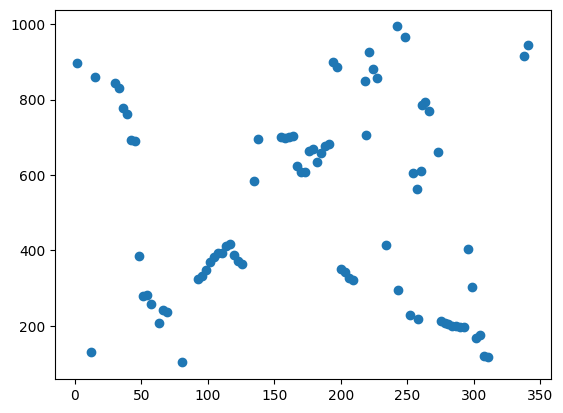

In [11]:
# importing matplotlib module
from matplotlib import pyplot as plt
import numpy as np

def plotVals(vals):
    x =[]
    y = []
    for i, val in enumerate(vals):
        if val > 100 and val < 1000:
            x.append(i)
            y.append(val)
    plt.scatter(x, y)

plotVals(distances)
#plotVals(intensities)

plt.show()

In [12]:
device._board.close()